In [72]:
from tensorflow.keras import layers, losses
from tensorflow import keras
from PIL import Image
import os.path
import datetime

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import os

In [2]:
def get_model():
    # Define general parameters of layers
    num_kernels = 20
    max_pool_size = (2, 2)
    kernel_reg = None
    conv_activation_func = None
    activation_func = 'relu'

    # Input are 100x100 pictures with 4 channels
    inputs = layers.Input(shape=(100, 100, 4))

    ## Create a contracting part with 3 Conv-Conv-Pool Layers
    ## Use the output of the second Conv Layer as input to embedding
    c0 = layers.Conv2D(num_kernels, activation=conv_activation_func, kernel_size=3, kernel_regularizer=kernel_reg,
                       data_format='channels_last')(inputs)
    
    p1 = layers.MaxPool2D(pool_size=max_pool_size, strides=max_pool_size, padding='valid',
                          data_format='channels_last')(c0)

    c2 = layers.Conv2D(2 * num_kernels, activation=conv_activation_func, kernel_size=3, kernel_regularizer=kernel_reg,
                       data_format='channels_last')(p1)
    
    p2 = layers.MaxPool2D(pool_size=max_pool_size, strides=max_pool_size, padding='valid',
                          data_format='channels_last')(c2)

    c4 = layers.Conv2D(2 ** 2 * num_kernels, activation=conv_activation_func, kernel_size=3, kernel_regularizer=kernel_reg,
                       data_format='channels_last')(p2)
    
    p3 = layers.MaxPool2D(pool_size=max_pool_size, strides=max_pool_size, padding='valid',
                          data_format='channels_last')(c4)

    # Flatten Layer to change dimensions
    f1 = layers.Flatten()(p3)

    # Create dense encoding layer connected to the conv layers
    d1 = layers.Dense(500, activation=activation_func, kernel_regularizer=kernel_reg)(f1)

    ## Class prediction

    # Create another dense layer
    d2 = layers.Dense(500, activation=activation_func, kernel_regularizer=kernel_reg)(d1)
    output_classes = layers.Dense(10, activation='softmax', kernel_regularizer=kernel_reg)(d2)

    return keras.Model(
        inputs=[inputs],
        outputs=[output_classes],
    )

In [3]:
# For the cluster
#path = os.path.join(str(os.environ['TMP_LOCAL']), 'species_classification/')
path = r'./species_classification/'

if os.path.isdir(path): 
    print("PATH IS FINE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"The path is: {path}")
else:
    print("path is broken.")

PATH IS FINE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
The path is: ./species_classification/


In [20]:
def load_data(path):
    """Loads the data as numpy array.

    :param path: The path to the overheading folder containing subfolders of classes, which contain the images.
    :return: A numpy array containing the images and classes.
    
    """
    # Counter to make things more efficient
    num_files = 0

    # Find total number of files to be read
    for folder in os.listdir(path):
        cur_path = os.path.join(path, folder)
        num_files += len([f for f in os.listdir(cur_path)
                              if os.path.isfile(os.path.join(cur_path, f))])

    # Track the current index with respect to the number of total files
    total_idx = 0

    # Initialize X and Y once to make things more efficient
    # Save 100x100x4 images and one-hot encoding with 10 classes
    total_x = np.zeros((num_files, 100, 100, 4))
    total_y = np.zeros((num_files, 10))

    # Go through each sub-/class-folder
    for idx, folder in enumerate(os.listdir(path)):
        cur_path = os.path.join(path, folder)

        # For each image path
        for file_name in os.listdir(cur_path):
            # Get one-hot encoding
            cur_y = np.zeros((1, 10))
            cur_y[0, idx] = 1

            # Save current y in the resulting array
            total_y[total_idx] = cur_y

            # Load image as np array
            file_path = os.path.join(cur_path, file_name)
            img = Image.open(file_path)
            cur_x = np.array(img.getdata(), dtype=np.float32)
            w, h = img.size
            cur_x.shape = (1, h, w, cur_x.size // (w * h))

            # Normalize to range [0, 1]
            cur_x /= 255

            # Save image
            total_x[total_idx] = cur_x

            # Increase index
            total_idx += 1


    # Split data with ratio Train/Test 0.8/0.2
    return train_test_split(total_x, total_y, test_size=0.2, random_state=42)

In [21]:
# Get data and weights
print("USED PATH SUCCESSFULLY!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
X_train, X_test, Y_train, Y_test = load_data(path)
print(f"Time: {datetime.datetime.now()}, Split Data")

USED PATH SUCCESSFULLY!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Time: 2023-04-13 12:29:06.121254, Split Data


In [96]:
# Generate class weights for loss
tuples_y = []
for i in range(len(Y_train)):
    cur_tup = []
    for j in range(len(Y_train[i])):
        if Y_train[i, j]:
            cur_tup.append(j)
    tuples_y.append(tuple(cur_tup))
tuples_y = tuple(tuples_y)

weights = compute_class_weight('balanced', classes=((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,)),
                               y=tuples_y)

class_weights = dict(enumerate(weights))

C:\opt\miniconda3\envs\dl_bip\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\opt\miniconda3\envs\dl_bip\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [62]:
# Use data augmentation:
#   - Rotating Images up to 180°
#   - Move image up to 30% vertically and horizontally
#   - Flip image vertically and horizontally
#   - Zoom out/in up to 20%
#   - Shear up to 45°
# Split data Train/Validation 0.8/0.2 
#   => Overall 64%/14%/20% for train/validation/test respectively
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    zoom_range=0.2,
    shear_range=45
)

# Use augmentation on training data
datagen.fit(X_train)

In [85]:
# Determine batch size for later use
batch_size = 150
model = get_model()
print("Created Model")
model.summary()
# keras.utils.plot_model(model, "our_model.png", show_shapes=True)
# print("Plotted Model Architecture")

# Use Categorical Corssentropy, Adam and Categorical Accuracy
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer='adam',
    metrics=[keras.metrics.CategoricalAccuracy()],
)

# Implement saving best model by setting patience >= epochs
# and using restore_best_weights = True
# Workaround since the normal Callback generates a permission
# error when used on the cluster
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    mode='max',
    patience=200,
    restore_best_weights=True
)

Created Model
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 100, 4)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 98, 98, 20)        740       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 49, 49, 20)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 47, 47, 40)        7240      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 23, 23, 40)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 21, 21, 80)        28880     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 10, 10, 8

In [86]:
# Fits the model on batches with real-time data augmentation:
history = model.fit(datagen.flow(X_train,
	               Y_train,
		       batch_size=batch_size,
		       subset='training'
	  ),
         validation_data=datagen.flow(X_train,
				      Y_train,
				      batch_size=batch_size,
  				      subset='validation'
          ),
         steps_per_epoch=(0.8*len(X_train)) // batch_size,
         validation_steps=(0.2*len(X_train)) // batch_size,
         epochs=200,
         verbose=2,
         callbacks=[
             early_stopping_callback
         ],
         class_weight=class_weights
)
print("Finished Training Model")

Epoch 1/200
31/31 - 16s - loss: 2.0318 - categorical_accuracy: 0.2182 - val_loss: 1.7413 - val_categorical_accuracy: 0.3495
Epoch 2/200
31/31 - 15s - loss: 1.6594 - categorical_accuracy: 0.3574 - val_loss: 1.3882 - val_categorical_accuracy: 0.4857
Epoch 3/200
31/31 - 14s - loss: 1.3599 - categorical_accuracy: 0.4412 - val_loss: 1.4026 - val_categorical_accuracy: 0.4210
Epoch 4/200
31/31 - 15s - loss: 1.2551 - categorical_accuracy: 0.4621 - val_loss: 1.4952 - val_categorical_accuracy: 0.4067
Epoch 5/200
31/31 - 14s - loss: 1.2439 - categorical_accuracy: 0.4787 - val_loss: 1.1180 - val_categorical_accuracy: 0.5743
Epoch 6/200
31/31 - 15s - loss: 1.1201 - categorical_accuracy: 0.5335 - val_loss: 1.0298 - val_categorical_accuracy: 0.6238
Epoch 7/200
31/31 - 14s - loss: 1.0436 - categorical_accuracy: 0.5878 - val_loss: 1.3161 - val_categorical_accuracy: 0.5105
Epoch 8/200
31/31 - 15s - loss: 1.2217 - categorical_accuracy: 0.4980 - val_loss: 1.2271 - val_categorical_accuracy: 0.5476
Epoch 9/

Epoch 67/200
31/31 - 14s - loss: 0.5812 - categorical_accuracy: 0.7758 - val_loss: 0.6108 - val_categorical_accuracy: 0.7848
Epoch 68/200
31/31 - 14s - loss: 0.5008 - categorical_accuracy: 0.8175 - val_loss: 0.5389 - val_categorical_accuracy: 0.8162
Epoch 69/200
31/31 - 16s - loss: 0.5164 - categorical_accuracy: 0.8000 - val_loss: 0.6123 - val_categorical_accuracy: 0.7829
Epoch 70/200
31/31 - 15s - loss: 0.5063 - categorical_accuracy: 0.8080 - val_loss: 0.6945 - val_categorical_accuracy: 0.7676
Epoch 71/200
31/31 - 14s - loss: 0.6045 - categorical_accuracy: 0.7809 - val_loss: 0.7520 - val_categorical_accuracy: 0.7476
Epoch 72/200
31/31 - 15s - loss: 0.5077 - categorical_accuracy: 0.8113 - val_loss: 0.5865 - val_categorical_accuracy: 0.8010
Epoch 73/200
31/31 - 15s - loss: 0.6034 - categorical_accuracy: 0.7714 - val_loss: 0.5936 - val_categorical_accuracy: 0.7857
Epoch 74/200
31/31 - 15s - loss: 0.5419 - categorical_accuracy: 0.7909 - val_loss: 0.5560 - val_categorical_accuracy: 0.8048


Epoch 133/200
31/31 - 15s - loss: 0.3864 - categorical_accuracy: 0.8534 - val_loss: 0.5248 - val_categorical_accuracy: 0.8162
Epoch 134/200
31/31 - 15s - loss: 0.3589 - categorical_accuracy: 0.8645 - val_loss: 0.5796 - val_categorical_accuracy: 0.7981
Epoch 135/200
31/31 - 15s - loss: 0.3488 - categorical_accuracy: 0.8676 - val_loss: 0.4950 - val_categorical_accuracy: 0.8524
Epoch 136/200
31/31 - 15s - loss: 0.3599 - categorical_accuracy: 0.8639 - val_loss: 0.4768 - val_categorical_accuracy: 0.8486
Epoch 137/200
31/31 - 15s - loss: 0.3936 - categorical_accuracy: 0.8472 - val_loss: 0.5027 - val_categorical_accuracy: 0.8419
Epoch 138/200
31/31 - 15s - loss: 0.3224 - categorical_accuracy: 0.8832 - val_loss: 0.5810 - val_categorical_accuracy: 0.8000
Epoch 139/200
31/31 - 15s - loss: 0.3353 - categorical_accuracy: 0.8694 - val_loss: 0.4604 - val_categorical_accuracy: 0.8610
Epoch 140/200
31/31 - 15s - loss: 0.3715 - categorical_accuracy: 0.8559 - val_loss: 0.6471 - val_categorical_accuracy:

31/31 - 15s - loss: 0.3265 - categorical_accuracy: 0.8654 - val_loss: 0.5686 - val_categorical_accuracy: 0.8190
Epoch 199/200
31/31 - 15s - loss: 0.3268 - categorical_accuracy: 0.8681 - val_loss: 0.5363 - val_categorical_accuracy: 0.8410
Epoch 200/200
31/31 - 15s - loss: 0.2991 - categorical_accuracy: 0.8749 - val_loss: 0.5273 - val_categorical_accuracy: 0.8276
Finished Training Model


Plotted Performance


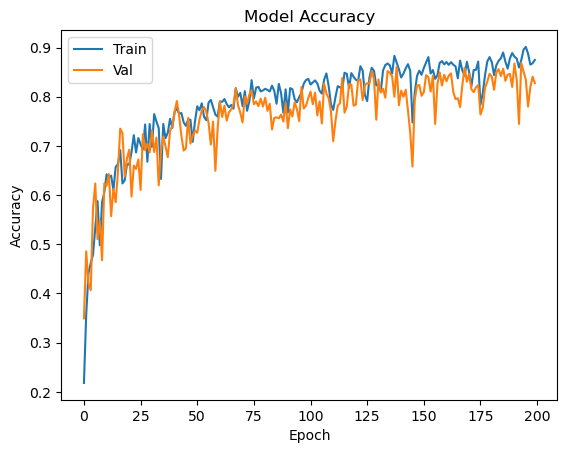

In [92]:
# Plot accuracy and loss
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("./accuracy_plot.png")
#plt.cla()
print("Plotted Performance")

Plotted Performance


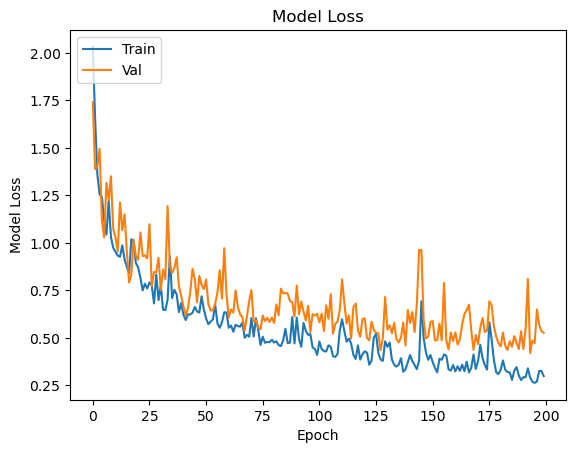

In [94]:
# Plot accuracy and loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Model Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("./loss_plot.png")
#plt.cla()
print("Plotted Performance")

Total accuracy:  0.8194921070693205
F1 score:  0.8240377526535305


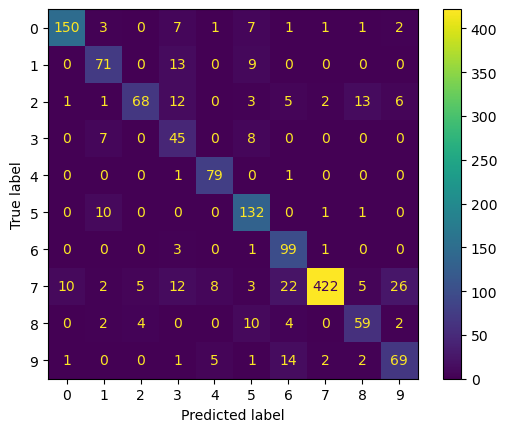

In [95]:
# Test model on test data and save conf mat
# Best model is used
Y_pred = model.predict(X_test)

class_encoding_y = np.argmax(Y_test, axis=1) + 1
predicted_class_y = np.argmax(Y_pred, axis=1) + 1

mat = confusion_matrix(class_encoding_y, predicted_class_y)
disp = ConfusionMatrixDisplay(confusion_matrix=mat)

disp.plot()
print("Total accuracy: ", accuracy_score(class_encoding_y, predicted_class_y))
print("F1 score: ", f1_score(class_encoding_y, predicted_class_y, average='weighted'))
plt.savefig("./conf_mat.png")